In [95]:
RUN_MINI_BATCH_COMPARISON=True #Turn off for faster run
SAVE_PLOTS=False

In [96]:
#Enable autoreloading of imported modules
%load_ext autoreload
%autoreload 2

#Import required packages
import sys,os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sp
from IPython.display import display

#Add the repo root (one level up from this notebook) to sys.path
sys.path.insert(0, os.path.abspath("../"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
#Install necessary resources from nltk
import nltk

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\phili\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\phili\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\phili\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## 1. Download data

In [98]:
import kagglehub

#Download latest version of dataset
print("Load or download dataset...")
path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset") #path to downloaded dataset
#   (if already downloaded, will not download again)

fake_path=os.path.join(path, "Fake.csv")    #path to dataset with true news
true_path=os.path.join(path, "True.csv")    #path to dataset with fake news

#Read into dataframes
print("Loading fake.csv ...")
fake_df=pd.read_csv(fake_path)
print("Loading true.csv ...")
true_df=pd.read_csv(true_path)

#Label data (1=true, 0=fakenews)
true_df['label']=1
fake_df['label']=0

#Join dataframes
df=pd.concat([true_df, fake_df])
print("Done")


Load or download dataset...
Loading fake.csv ...
Loading true.csv ...
Done


## 2. Preprocess data

In [99]:
from courselib.utils.splits import train_test_split

training_data_fraction=.8

#Split
df_, train_df, test_df=train_test_split(df, training_data_fraction=training_data_fraction, class_column_name='label', return_numpy=False)

In [100]:
from sklearn.feature_extraction.text import TfidfVectorizer
from courselib.utils.normalization import standardize_sparse_matrix

column='title' #column of df to vectorize


#Vectorize train, test split
vectorizer=TfidfVectorizer()
X_train=vectorizer.fit_transform((train_df[column]))
X_test=vectorizer.transform((test_df[column]))
X=sp.vstack([X_train, X_test])

Y_train=train_df['label'].to_numpy()
Y_test=test_df['label'].to_numpy()

#-1, 1 labels for SVM
Y_train_neg=Y_train.copy()
Y_train_neg[Y_train_neg==0]=-1
Y_test_neg=Y_test.copy()
Y_test_neg[Y_test_neg==0]=-1

#Apply additional z-score normalization (works better for svm)
X, offset=standardize_sparse_matrix(X)
X_train, X_test=X[:len(train_df)], X[len(train_df):]

In [101]:
num_features=X_train.shape[1] #number of extracted features from train_df[column]
num_features

19601

## 3. Comparison of different models

In [102]:
from courselib.models.glm import LogisticRegression
from courselib.models.svm import LinearSVM, BinaryKernelSVM
from courselib.optimizers import GDOptimizer

lr_LR=10 #learning rate LogisticRegression model
lr_SVM=0.001 #learning rate LinearSVM model

#Initialize optimizers
optimizer_LR=GDOptimizer(lr_LR) #optimizer LogisticRegression
optimizer_SVM=GDOptimizer(lr_SVM) #optimizer LinearSVM



In [103]:
import time
from courselib.utils.metrics import binary_accuracy

num_epochs=100 #number of epochs
bs=len(train_df) #batch size

results=[]


#Initialize models
w=np.zeros(num_features) #initial weight
b=0 #initial bias
model_LR=LogisticRegression(w,b, optimizer=optimizer_LR, offset=offset)
model_SVM=LinearSVM(w,b, optimizer=optimizer_SVM, offset=offset)

#Training:
metrics_dict_LR={'train accuracy': lambda y_pred,y_true: binary_accuracy(y_pred=y_pred, y_true=y_true, class_labels=[0,1]),
                'test accuracy': lambda y_pred,y_true: binary_accuracy(model_LR.decision_function(X_test),Y_test,class_labels=[0,1])}
metrics_dict_SVM={'train accuracy': lambda y_pred,y_true: binary_accuracy(y_pred=y_pred, y_true=y_true, class_labels=[-1,1]),
                'test accuracy': lambda y_pred,y_true: binary_accuracy(model_SVM.decision_function(X_test),Y_test_neg,class_labels=[-1,1])}

start_LR=time.time()
metrics_history_LR=model_LR.fit(X_train, Y_train, num_epochs=num_epochs, batch_size=bs, compute_metrics=True, metrics_dict=metrics_dict_LR)
end_LR=time.time()

start_SVM=time.time()
metrics_history_SVM=model_SVM.fit(X_train, Y_train_neg, num_epochs=num_epochs, batch_size=bs, compute_metrics=True, metrics_dict=metrics_dict_SVM)
end_SVM=time.time()


results.append({'model':'LogisticRegression', 'batch size': 'full' if bs==len(train_df) else bs,
         'train accuracy [%]':round(metrics_history_LR['train accuracy'][-1],2),
         'test accuracy [%]':round(metrics_history_LR['test accuracy'][-1],2), 'training time [s]': round(end_LR-start_LR,2)
         })
results.append({'model':'LinearSVM', 'batch size': 'full' if bs==len(train_df) else bs,
                'train accuracy [%]':round(metrics_history_SVM['train accuracy'][-1],2),
                'test accuracy [%]':round(metrics_history_SVM['test accuracy'][-1],2), 'training time [s]': round(end_SVM-start_SVM,2)
         })
results_df=pd.DataFrame(results)
results_df

,model,batch size,train accuracy [%],test accuracy [%],training time [s]
0,LogisticRegression,full,100.00,95.89,1.36
1,LinearSVM,full,99.39,95.72,1.51


Text(0.5, 1.0, 'Accuracy comparison')

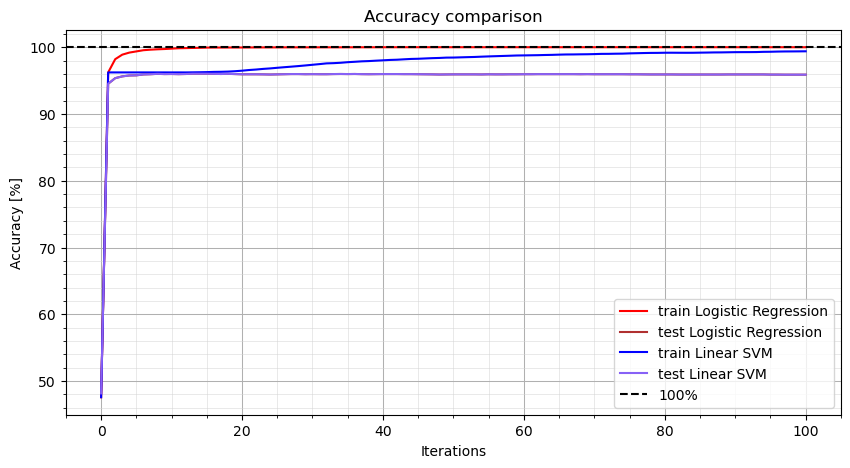

In [ ]:
#Plot
fig,ax=plt.subplots(figsize=(10,5))
ax.plot(range(len(metrics_history_LR['train accuracy'])),metrics_history_LR['train accuracy'], label="train Logistic Regression", color='red')
ax.plot(range(len(metrics_history_LR['test accuracy'])),metrics_history_LR['test accuracy'], label="test Logistic Regression", color="#B03030")
ax.plot(range(len(metrics_history_SVM['train accuracy'])),metrics_history_SVM['train accuracy'], label="train Linear SVM", color='blue')
ax.plot(range(len(metrics_history_SVM['test accuracy'])),metrics_history_LR['test accuracy'], label="test Linear SVM", color="#8761F6")
ax.axhline(y=100, color='black', linestyle='--', label='100%')
ax.legend()
ax.set_xlabel('Iterations')
ax.set_ylabel('Accuracy [%]')
# Turn on minor ticks automatically
ax.minorticks_on()

# Major grid: solid, normal
ax.grid(which='major', linestyle='-', linewidth=0.75)

# Minor grid: dashed, light
ax.grid(which='minor', linestyle='-', linewidth=0.5, color='lightgray', alpha=0.7)
ax.set_title('Accuracy comparison')
plt.show()


### 2.1. Comparison with mini batch

In [105]:
if RUN_MINI_BATCH_COMPARISON:    
       bs=100 #batch size to compare
       lr_LR2=0.01 #learning rate LogisticRegression model (this learning rate performed better for mini batch)
       lr_SVM2=0.001 #learning rate LinearSVM model

       #Initialize optimizers
       optimizer_LR2=GDOptimizer(lr_LR2) #optimizer LogisticRegression
       optimizer_SVM2=GDOptimizer(lr_SVM2) #optimizer LinearSVM


       model_LR2=LogisticRegression(w,b, optimizer=optimizer_LR2, offset=offset)
       model_SVM2=LinearSVM(w,b, optimizer=optimizer_SVM2, offset=offset)


       start_LR2=time.time()
       model_LR2.fit(X_train, Y_train, num_epochs=num_epochs, batch_size=bs)
       end_LR2=time.time()

       start_SVM2=time.time()
       model_SVM2.fit(X_train, Y_train_neg, num_epochs=num_epochs, batch_size=bs)
       end_SVM2=time.time()


       results.append({'model':'LogisticRegression', 'batch size': 'full' if bs==len(train_df) else bs,
              'train accuracy [%]':round(binary_accuracy(model_LR2(X_train), Y_train, class_labels=[0,1]),2),
              'test accuracy [%]':round(binary_accuracy(model_LR2(X_test), Y_test, class_labels=[0,1]),2), 
              'training time [s]': round(end_LR2-start_LR2,2)
              })
       results.append({'model':'LinearSVM2', 'batch size': 'full' if bs==len(train_df) else bs,
              'train accuracy [%]':round(binary_accuracy(model_SVM2(X_train), Y_train_neg, class_labels=[-1,1]),2),
              'test accuracy [%]':round(binary_accuracy(model_SVM2(X_test), Y_test_neg, class_labels=[-1,1]),2), 
              'training time [s]': round(end_SVM2-start_SVM2,2)
              })
       results_df=pd.DataFrame(results)
       display(results_df)

,model,batch size,train accuracy [%],test accuracy [%],training time [s]
0,LogisticRegression,full,100.00,95.89,1.36
1,LinearSVM,full,99.39,95.72,1.51
2,LogisticRegression,100,100.00,95.60,24.00
3,LinearSVM2,100,96.50,92.12,40.42
